# Energy Straggling and Radiation Reaction for Magnetic Breinsstrahlung

CS Shen and D White, [Phys Rev Lett __28__ 455 (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.28.455)

Notebook by Óscar Amaro, January 2023

In [1]:
# numpy
import numpy as np
np.random.seed(19680801)
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

# import functions
from scipy.special import kv, iv, erf
from scipy.integrate import quad
from numpy import log, log10, sin, cos, exp, sqrt, pi

# interpolate
from scipy import interpolate

# physical constants
from scipy.constants import speed_of_light, fine_structure, hbar, elementary_charge, electron_mass

tauC = hbar/(electron_mass*speed_of_light**2) # Compton length
ES = electron_mass**2*speed_of_light**3/elementary_charge/hbar # Schwinger field

# root finding
from scipy.optimize import fsolve
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm

# progress bar
from tqdm.notebook import tqdm
from tqdm import trange
from time import sleep
from tqdm import tqdm

# pickle
import pickle

# warnings
import warnings
warnings.simplefilter('ignore')

def arraycenter(x):
    """
    returns centered array for histograms
    """
    return np.array([(x[i]+x[i+1])/2 for i in range(len(x)-1)])

In [2]:
# import data extracted using WebPlotDigitizer
fig1a = pd.read_csv( "data/fig1a.txt", header=None)
fig1b = pd.read_csv( "data/fig1b.txt", header=None)
fig2 = pd.read_csv( "data/fig2.txt", header=None)

In [3]:
gmdim = 200 #[] grid dimension
tdim = 4000 # time resolution

def getEnergy(x):
    return np.trapz(x*gmlst,gmlst)/np.trapz(x,gmlst)

def getNumber(x):
    return np.trapz(x,gmlst)

In [19]:
# main parameters
E0 = 400 #[GeV]
Bfld = 5e2; # [T] magnetic field

tmax = 7.6e2 #[1/omega_B]
g0 = E0/0.511e-3 #[]
chi0 = 1e-3 * g0/1800 * Bfld/2.5e3 #[] approximate...
# gm
gmmin = 1 #[] minimum energy
gmmax = g0 #[] maximum energy Fig1a
dgm = gmmax/gmdim #[] interval in energy
gmlst = np.linspace(gmmin,gmmax,gmdim) #[] energy array

# reference omega_p
omega_B = elementary_charge/electron_mass/1800 * 2.5e3 * (chi0/(1e-3))
print("omega_B=",omega_B)
dt = tmax/tdim # time step
tlst = np.linspace(0,tmax,tdim) # time steps array

def dNdg(gg,gl):
    """
        photon emission nCS (Niel PhD §3.82)
    """
    chi = gl * speed_of_light*Bfld/ES
    chig = gg * speed_of_light*Bfld/ES
    xi = gg/gl
    if gg<=gmmin or gl<=gmmin or xi>=1:
        return 0
    nu = 2*xi/(3*chi*(1-xi))
    Gtil = sqrt(3)/2/pi*xi*( quad(lambda y: kv(5/3,y), nu, np.inf )[0] + 3/2*chig*nu*kv(2/3,nu) )
    res = 1/omega_B * 2/3 * fine_structure/tauC * Gtil/gl/gg
    return res

# define matrix {e-, g} and submatrices
dfdt_mat = np.zeros((gmdim,gmdim))
dfdt_mat_11_i = np.zeros_like(dfdt_mat)
dfdt_mat_11_o = np.zeros_like(dfdt_mat)

# electron: outgoing
for i in range(gmdim):
    dfdt_mat_11_o[i,i] = -np.sum( np.array([dNdg(g,gmlst[i]) for g in gmlst[gmlst<gmlst[i]]]) ) * dgm
# electron: ingoing
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_11_i[i,j] = dNdg(gmlst[j]-gmlst[i],gmlst[j]) * dgm
# add all submatrices
dfdt_mat = dfdt_mat_11_i+dfdt_mat_11_o
    
def dfdt(yn):
    """
    matrix multiplication
    does not depend explicitly on time
    """
    res = np.matmul(dfdt_mat,yn)
    return res

# initial condition
yn = np.zeros(gmdim)
yn[np.abs(gmlst-g0).argmin()] = 1 # Dirac

# for each time step
ffiga = np.zeros((tdim,gmdim))
ffiga[0,:] = yn
Energydumps_a = np.zeros(tdim)
Numberdumps_a = np.zeros(tdim)
Chidumps_a = np.zeros(tdim)
Energydumps_a[0] = getEnergy(yn[:gmdim])/g0
Numberdumps_a[0] = getNumber(yn[:gmdim])

for t in tqdm(range(1,tdim)):
    k1 = dfdt(yn)
    k2 = dfdt(yn+dt*k1/2)
    k3 = dfdt(yn+dt*k2/2)
    k4 = dfdt(yn+dt*k3)
    yn = yn + dt/6 * (k1 + 2*k2 + 2*k3 + k4) # RK4
    yn[yn<=0] = 0
    
    # save
    Energydumps_a[t] = getEnergy(yn)/g0
    Numberdumps_a[t] = getNumber(yn)
    ffiga[t,:] = yn

omega_B= 21246406353702.05


100%|██████████| 3999/3999 [00:00<00:00, 4360.27it/s]


In [24]:
g0/1800

1087.192868014786

In [21]:
# main parameters
E0 = 1000 #[GeV]
Bfld = 10e2; # [T] magnetic field

tmax = 15e2 #[1/omega_B]
g0 = E0/0.511e-3 #[]
chi0 = 1e-3 * g0/1800 * Bfld/2.5e3 #[] approximate...
# gm
gmmin = 1 #[] minimum energy
gmmax = g0 #[] maximum energy Fig1a
dgm = gmmax/gmdim #[] interval in energy
gmlst = np.linspace(gmmin,gmmax,gmdim) #[] energy array

# reference omega_p
omega_B = elementary_charge/electron_mass/1800 * 2.5e3 * (chi0/(1e-3))
print("omega_B=",omega_B)
dt = tmax/tdim # time step
tlst = np.linspace(0,tmax,tdim) # time steps array

def dNdg(gg,gl):
    """
        photon emission nCS (Niel PhD §3.82)
    """
    chi = gl * speed_of_light*Bfld/ES
    chig = gg * speed_of_light*Bfld/ES
    xi = gg/gl
    if gg<=gmmin or gl<=gmmin or xi>=1:
        return 0
    nu = 2*xi/(3*chi*(1-xi))
    Gtil = sqrt(3)/2/pi*xi*( quad(lambda y: kv(5/3,y), nu, np.inf )[0] + 3/2*chig*nu*kv(2/3,nu) )
    res = 1/omega_B * 2/3 * fine_structure/tauC * Gtil/gl/gg
    return res

# define matrix e- submatrices
dfdt_mat = np.zeros((gmdim,gmdim))
dfdt_mat_11_i = np.zeros_like(dfdt_mat)
dfdt_mat_11_o = np.zeros_like(dfdt_mat)

# electron: outgoing
for i in range(gmdim):
    dfdt_mat_11_o[i,i] = -np.sum( np.array([dNdg(g,gmlst[i]) for g in gmlst[gmlst<gmlst[i]]]) ) * dgm
# electron: ingoing
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_11_i[i,j] = dNdg(gmlst[j]-gmlst[i],gmlst[j]) * dgm
# add all submatrices
dfdt_mat = dfdt_mat_11_i+dfdt_mat_11_o
    
def dfdt(yn):
    """
    matrix multiplication
    does not depend explicitly on time
    """
    res = np.matmul(dfdt_mat,yn)
    return res

# initial condition
yn = np.zeros(gmdim)
yn[np.abs(gmlst-g0).argmin()] = 1 # Dirac
    
# for each time step
ffigb = np.zeros((tdim,gmdim))
Energydumps_b = np.zeros(tdim)
Numberdumps_b = np.zeros(tdim)
Chidumps_b = np.zeros(tdim)
ffigb[0,:] = yn
Energydumps_b[0] = getEnergy(yn[:gmdim])/g0
Numberdumps_b[0] = getNumber(yn[:gmdim])

for t in tqdm(range(1,tdim)):
    k1 = dfdt(yn)
    k2 = dfdt(yn+dt*k1/2)
    k3 = dfdt(yn+dt*k2/2)
    k4 = dfdt(yn+dt*k3)
    yn = yn + dt/6 * (k1 + 2*k2 + 2*k3 + k4) # RK4
    yn[yn<=0] = 0
    
    # save
    Energydumps_b[t] = getEnergy(yn)/g0
    Numberdumps_b[t] = getNumber(yn)
    ffigb[t,:] = yn

omega_B= 106232031768510.28


100%|██████████| 3999/3999 [00:00<00:00, 4474.56it/s]


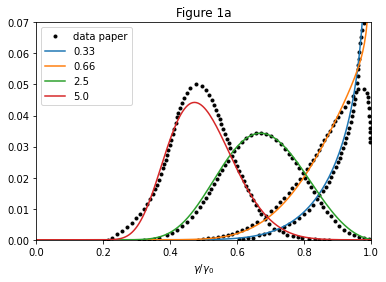

<gamma_q>/g0:
paper: 0.95, 0.90, 0.68, 0.50
notebook: 0.9338738136609956 0.8866726604453494 0.6731689187515794 0.4973404254460826


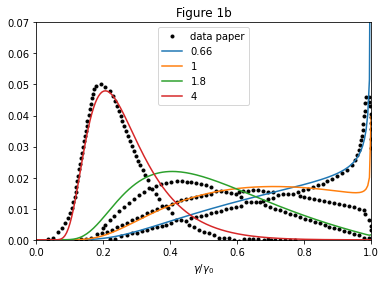

<gamma_q>/g0:
paper: 0.77, 0.65, 0.51, 0.25
notebook: 0.7526883789383083 0.6653943622545513 0.5044638163736177 0.2736749291304853


In [27]:
# Fig 1 a
plt.plot(fig1a[0], fig1a[1], '.k', label=r'data paper')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffiga[int(tdim*0.33/5)], label=r'0.33')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffiga[int(tdim*0.66/5)], label=r'0.66')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffiga[int(tdim*2.5/5)], label=r'2.5')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffiga[int(tdim*4.999/5)], label=r'5.0')
plt.title(r'Figure 1a')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.xlim([0,1])
plt.ylim([0,0.07])
plt.legend()
plt.show()
print("<gamma_q>/g0:")
print("paper: 0.95, 0.90, 0.68, 0.50" )
print("notebook:", Energydumps_a[int(tdim*0.33/5)], Energydumps_a[int(tdim*0.66/5)], Energydumps_a[int(tdim*2.5/5)], Energydumps_a[int(tdim*4.999/5)] )

# Fig 1 b
plt.plot(fig1b[0], fig1b[1], '.k', label=r'data paper')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffigb[int(tdim*0.66/4)], label=r'0.66')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffigb[int(tdim*1/4)], label=r'1')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffigb[int(tdim*1.8/4)], label=r'1.8')
plt.plot(gmlst/g0, 0.65*gmdim/60* ffigb[int(tdim*3.999/4)], label=r'4')
plt.title(r'Figure 1b')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.xlim([0,1])
plt.ylim([0,0.07])
plt.legend()
plt.show()
print("<gamma_q>/g0:")
print("paper: 0.77, 0.65, 0.51, 0.25" )
print("notebook:", Energydumps_b[int(tdim*0.66/4)], Energydumps_b[int(tdim*1/4)], Energydumps_b[int(tdim*1.8/4)], Energydumps_b[int(tdim*3.999/4)] )

In [11]:
# cumulative spectrum for non-monoenergetic electrons (ie, considering quantum spreading up to last time-step)
dNdgtmp = np.zeros_like(gmlst)
dNdgtmptot = np.zeros_like(gmlst)
tdimc = int(tdim*1.8/4)
tdimtdimc = 60
for k in trange(tdimtdimc):
    dNde = ffigb[int(tdim*1.8/4 * k/tdimtdimc )]
    for i in range(len(dNde)):
        dNdgtmp = dNdgtmp + dNde[i] *  np.array([dNdg(gmlst[j],gmlst[i]) for j in range(len(gmlst))])
    dNdgtmptot = dNdgtmptot + dNdgtmp/tdimtdimc
Iczt = np.copy(dNdgtmptot) * gmlst

100%|██████████| 60/60 [05:19<00:00,  5.32s/it]


In [12]:
# instantaneous spectrum for non-monoenergetic electrons (ie, considering quantum spreading for last time-step)
dNdgtmp = np.zeros_like(gmlst)
dNde = ffigb[int(tdim*1.8/4)]
for i in trange(len(dNde)):
    dNdgtmp = dNdgtmp + dNde[i] *  np.array([dNdg(gmlst[j],gmlst[i]) for j in range(len(gmlst))])
Izt = np.copy(dNdgtmp) * gmlst

100%|██████████| 200/200 [00:07<00:00, 25.09it/s]


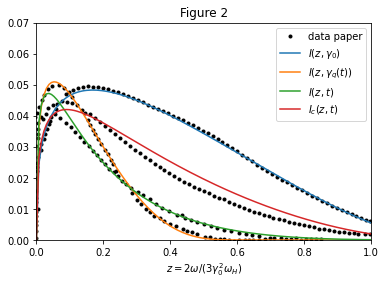

In [26]:
# Fig 2

# instantaneous spectrum assuming monoenergetic electrons with g0
Izg0 = np.array([gmlst[i] * dNdg(gmlst[i],g0) for i in range(len(gmlst))])

# instantaneous spectrum assuming monoenergetic electrons with average "quantum" energy
# the average "quantum" energy for 1000GeV 10MG at 1.8 MG cm was 0.51 g0
Izgqt = np.array([gmlst[i] * dNdg(gmlst[i],0.51*g0) for i in range(len(gmlst))])

plt.plot(fig2[0], fig2[1], '.k', label=r'data paper')
plt.plot(gmlst/g0*1.5, Izg0*18, label=r'$I(z,\gamma_0)$')
plt.plot(gmlst/g0*1.5, Izgqt*18, label=r'$I(z,\gamma_q(t))$')
plt.plot(gmlst/g0*1.5, Izt*18, label=r'$I(z,t)$')
plt.plot(gmlst/g0*1.5, Iczt/np.max(Iczt)*0.042, label=r'$I_c(z,t)$')
plt.title(r'Figure 2')
plt.xlabel(r'$z=2\omega /(3\gamma_0^2 \omega_H)$')
plt.xlim([0,1])
plt.ylim([0,0.07])
plt.legend()
plt.show()